In [16]:
pip install pandas seaborn numpy matplotlib scikit-learn xgboost scipy networkx torch torch-geometric hypernetx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.6/73.6 MB 1.6 MB/s  0:00:39m0:00:0100:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 2.2 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.4/591.4 kB 2.1 MB/s  0:00:0036m-:--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 2.6 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 2.3 MB/s  0:00:02 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.2/536.2 kB 1.9 MB/s  0:00:0036m-:--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18/18 [hypernetx]18 [torch-geometric]
Note: you may need to restart the kernel to use updated packages.


In [9]:
import pandas as pd
import seaborn as sns
import numpy as np
import itertools
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, validation_curve
from sklearn.metrics import precision_score, f1_score, recall_score, roc_auc_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler
from xgboost import XGBClassifier
from scipy.stats import ttest_ind
import networkx as nx
from collections import Counter
import warnings
import hypernetx as hnx

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203769 entries, 0 to 203768
Columns: 167 entries, 0 to 166
dtypes: float64(165), int64(2)
memory usage: 259.6 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203769 entries, 0 to 203768
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   txId    203769 non-null  int64 
 1   class   203769 non-null  object
dtypes: int64(1), object(1)
memory usage: 3.1+ MB
Total columns: 167


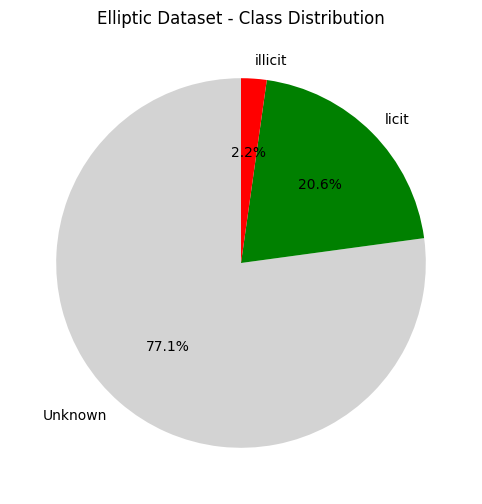

In [10]:
warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", lambda x: "%.3f" % x)
pd.set_option("display.width", 500)

# Data Preparation
features = pd.read_csv('fraud-detection-dataset/elliptic_txs_features.csv',header=None)
classes = pd.read_csv('fraud-detection-dataset/elliptic_txs_classes.csv')
features.info()
classes.info()
colNames1 = {'0': 'txId', 1: "Time step"}
colNames2 = {str(ii+2): "Local_feature_" + str(ii+1) for ii in range(93)}
colNames3 = {str(ii+95): "Aggregate_feature_" + str(ii+1) for ii in range(72)}

colNames = dict(colNames1, **colNames2, **colNames3)
colNames = {int(jj): item_kk for jj,item_kk in colNames.items()}

# Apply to dataframe
features.rename(columns=colNames, inplace=True)

print(f"Total columns: {len(features.columns)}")

df = features.merge(classes, on='txId')

df.head()

features.head()
classes.head()

df.loc[df['class'] == 'unknown', 'class'] = 3
df['class'] = df['class'].astype(int)
df["class"].value_counts(normalize=True) * 100
df.dtypes
# 3   77.149 unknown
# 2   20.621 licit
# 1    2.230 illicit

labels = ['Unknown', 'licit', 'illicit']
sizes = [77149, 20621, 2230]
colors = ['lightgray', 'green', 'red']

# Simple pie chart
plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Elliptic Dataset - Class Distribution')
plt.show()

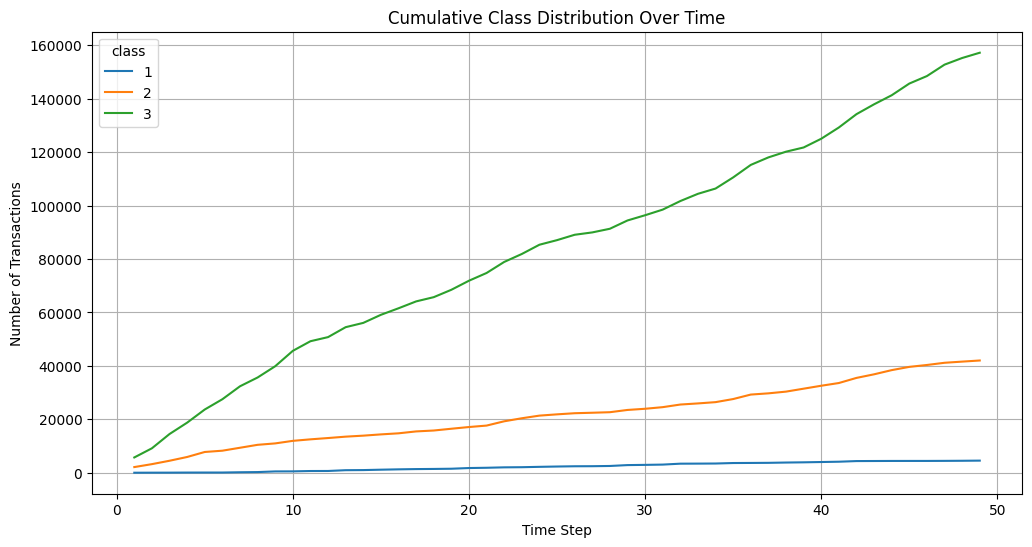

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203769 entries, 0 to 203768
Columns: 168 entries, txId to class
dtypes: float64(165), int64(3)
memory usage: 261.2 MB


txId                    False
Time step               False
Local_feature_1         False
Local_feature_2         False
Local_feature_3         False
                        ...  
Aggregate_feature_69    False
Aggregate_feature_70    False
Aggregate_feature_71    False
Aggregate_feature_72    False
class                   False
Length: 168, dtype: bool

In [11]:
# Time step analysis
df.groupby(['Time step', 'class']).size().unstack(fill_value=0).cumsum().plot(figsize=(12,6))
plt.title("Cumulative Class Distribution Over Time")
plt.xlabel("Time Step")
plt.ylabel("Number of Transactions")
plt.grid(True)
plt.show()

df.info()

df.isnull().any()

In [12]:
# Outlier handling
# ✅ Bitcoin whale transactions are expected and not removed

labeled_df = df[df['class'].isin([1, 2])].copy()
feature_cols = labeled_df.select_dtypes(include=['float64']).columns
labeled_df.head()
df['class'].unique()

# Exploratory Data Analysis
print("=== EXPLORATORY DATA ANALYSIS ===")
print(f"Labeled dataframe shape: {labeled_df.shape}")
print(f"Feature columns count: {len(feature_cols)}")
print(f"NaN values check:")
print(labeled_df[feature_cols].isnull().sum().sum()) 

labeled_df["class"].head()

# Feature scaling using RobustScaler
scaler = RobustScaler()
X_scaled = scaler.fit_transform(labeled_df[feature_cols])

df_final = pd.DataFrame(X_scaled, columns=feature_cols, index=labeled_df.index)
df_final['class'] = labeled_df['class']
df_final['txId'] = labeled_df['txId']
df_final['Time step'] = labeled_df['Time step']
df_final['class'] = df_final['class'].map({2: 0, 1: 1})  # 0: licit, 1: illicit
df_final.head()

df_final["class"].value_counts()

# Process unknown data with the same scaler
unknown_df = df[df['class'] == 3].copy()
X_unknown_scaled = scaler.transform(unknown_df[feature_cols])

# Unknown DataFrame preparation
df_unknown = pd.DataFrame(X_unknown_scaled, columns=feature_cols, index=unknown_df.index)
df_unknown['txId'] = unknown_df['txId']
df_unknown['Time step'] = unknown_df['Time step']
df_unknown['class'] = 3  # Keep original class
df_unknown.head()

print(f"✅ Labeled scaled shape: {df_final.shape}")
print(f"✅ Unknown scaled shape: {df_unknown.shape}")

=== EXPLORATORY DATA ANALYSIS ===
Labeled dataframe shape: (46564, 168)
Feature columns count: 165
NaN values check:
0
✅ Labeled scaled shape: (46564, 168)
✅ Unknown scaled shape: (157205, 168)


In [13]:
# Build a simple hypergraph: nodes = txId, hyperedges = transactions in the same timestep
hyperedges = {}
for t in df_final['Time step'].unique():
    tx_ids = df_final[df_final['Time step'] == t]['txId'].tolist()
    hyperedges[f"timestep_{t}"] = tx_ids

# Create Hypergraph
H = hnx.Hypergraph(hyperedges)

print(H)

None <class 'hypernetx.classes.hypergraph.Hypergraph'>


In [14]:
# Feature Importance Analysis using Statistical Tests
print("\n=== FEATURE IMPORTANCE (T-TEST) ===")
feature_importance = []

for feature in feature_cols:
    illicit_vals = df_final[df_final['class'] == 1][feature]
    licit_vals = df_final[df_final['class'] == 0][feature]

    if len(illicit_vals) > 0 and len(licit_vals) > 0:
        t_stat, p_value = ttest_ind(illicit_vals, licit_vals)
        feature_importance.append({
            'feature': feature,
            'p_value': p_value,
            'significant': p_value < 0.05,
            'difference': abs(illicit_vals.mean() - licit_vals.mean())
        })

importance_df = pd.DataFrame(feature_importance)
importance_df = importance_df.sort_values('p_value')
print("Most significant features (by p-value):")
print(importance_df.head(50))

# ⚡ p-value = 0.000 means:
# Features are statistically significant
# There's a real difference between the two groups
# The model can learn these differences

print(f"Total features: {len(importance_df)}")
print(f"Significant features: {importance_df['significant'].sum()}")
print(f"Non-significant features: {(~importance_df['significant']).sum()}")


=== FEATURE IMPORTANCE (T-TEST) ===
Most significant features (by p-value):
                  feature  p_value  significant  difference
90       Local_feature_91    0.000         True       0.439
149  Aggregate_feature_57    0.000         True       0.337
88       Local_feature_89    0.000         True       0.441
52       Local_feature_53    0.000         True       0.551
141  Aggregate_feature_49    0.000         True       5.143
89       Local_feature_90    0.000         True       0.591
54       Local_feature_55    0.000         True       0.567
51       Local_feature_52    0.000         True       0.641
153  Aggregate_feature_61    0.000         True       6.731
53       Local_feature_54    0.000         True       1.027
113  Aggregate_feature_21    0.000         True       0.524
147  Aggregate_feature_55    0.000         True       0.217
155  Aggregate_feature_63    0.000         True       0.595
82       Local_feature_83    0.000         True       1.215
84       Local_feature_

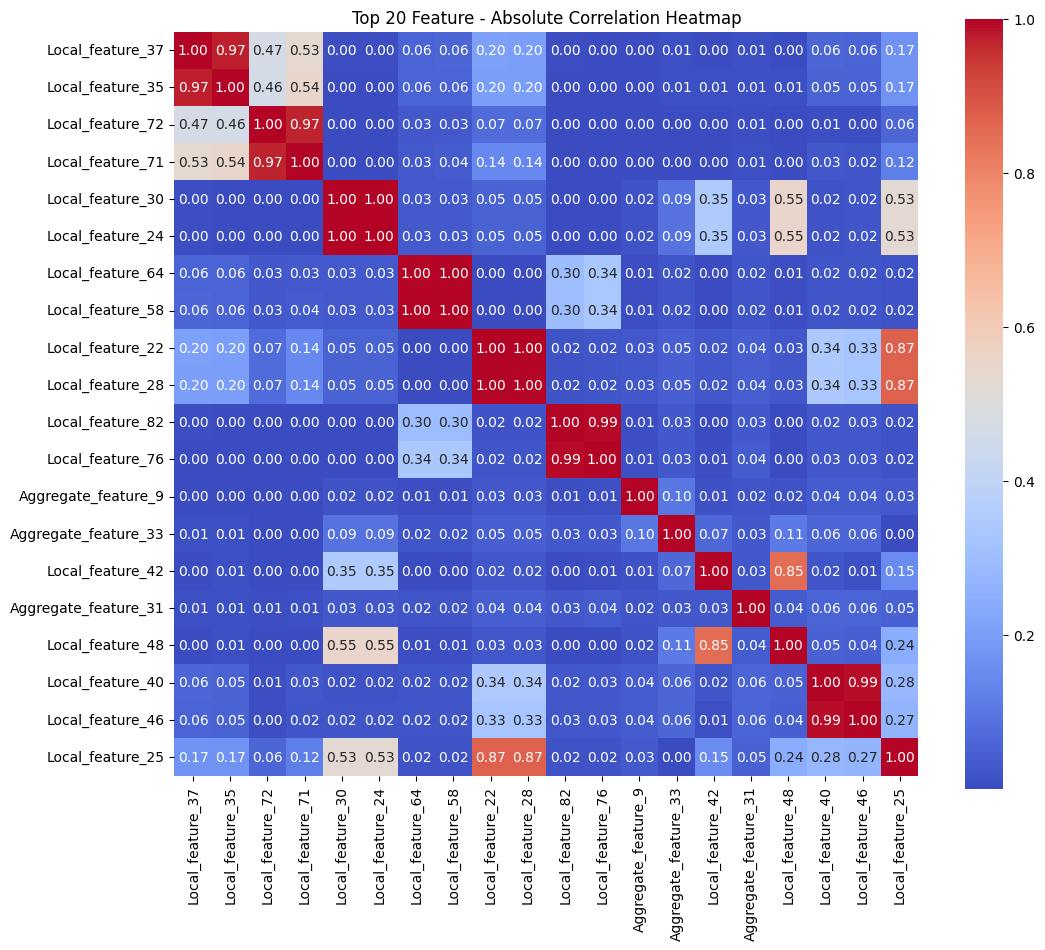

In [15]:
# Correlation Heatmap
top_features = importance_df.sort_values(["significant", "difference"], ascending=[False, False])\
                            .head(20)["feature"].tolist()

corr_matrix = df_final[top_features].corr().abs()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Top 20 Feature - Absolute Correlation Heatmap")
plt.show()

# Analysis note: "In correlation analysis, high correlation was not observed among significant features.
# This indicates the presence of various independent signals that the model can learn,
# while also revealing that the risk of multicollinearity is low.
# Therefore, all features can be directly included in the model."

In [25]:
# Node degrees (number of hyperedges a node belongs to)
degrees = pd.Series({node: H.degree(node) for node in H.nodes()})

# Hyperedge clustering coefficient (optional advanced feature)
# Here we just use degree as a simple embedding
hypergraph_embeddings = pd.DataFrame({'txId': degrees.index, 'hyper_degree': degrees.values})

# Merge embeddings with original features
df_hyper = df_final.merge(hypergraph_embeddings, on='txId', how='left')

X = df_hyper.drop(['class', 'txId', 'Time step'], axis=1)
y = df_hyper['class']

Fitting 5 folds for each of 24 candidates, totalling 120 fits
F1Score: 0.781386537049225
ROC_AUC: 0.9747629084990553


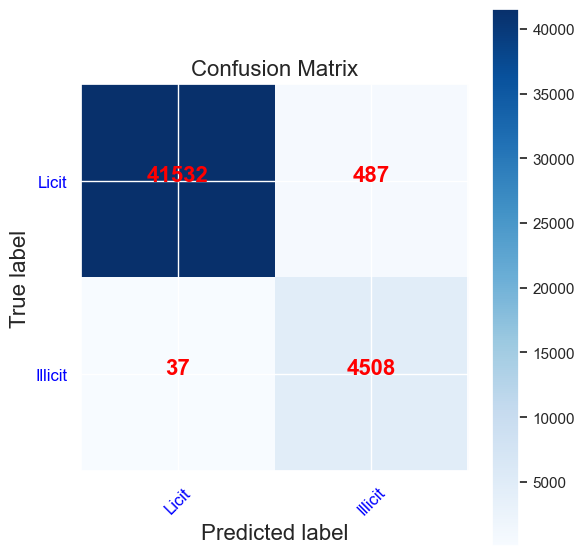

In [43]:
# XGBoost Model Training
X = df_hyper.drop(['class', 'txId', 'Time step'], axis=1)
y = df_hyper['class']

# Handle class imbalance: scale_pos_weight = licit/illicit ≈ 9.25
xgboost_model = XGBClassifier(random_state=17, eval_metric='logloss', scale_pos_weight=9.25)
xgboost_model.get_params()

xgboost_params = {"learning_rate": [0.1, 0.011],
                  "max_depth": [5, 8],
                  "n_estimators": [100, 200, 500],
                  "colsample_bytree": [0.7, 1]}

xgboost_best_grid = GridSearchCV(xgboost_model, xgboost_params, cv=5, n_jobs=-1, verbose=True).fit(X, y)

# Best params: 'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 500
xgboost_final = xgboost_model.set_params(**xgboost_best_grid.best_params_, random_state=17).fit(X, y)

# Cross-validation results
cv_results = cross_validate(xgboost_final, X, y, cv=5, n_jobs=-1, scoring=["f1", "roc_auc"])

print(f"F1Score: {(cv_results['test_f1']).mean()}")  # F1Score: 0.779
print(f"ROC_AUC: {(cv_results['test_roc_auc']).mean()}")  # ROC_AUC: 0.977

# Confusion Matrix
y_pred = xgboost_final.predict(X)
cm = confusion_matrix(y, y_pred)

def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(6, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontdict={'size': 16})
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=12, color="blue")
    plt.yticks(tick_marks, classes, fontsize=12, color="blue")

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),  # 'd' = integer
                 horizontalalignment="center",
                 color="red", fontsize=16, weight='bold')

    plt.ylabel('True label', fontdict={'size': 16})
    plt.xlabel('Predicted label', fontdict={'size': 16})
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(cm, classes=['Licit','Illicit'],
                      title='Confusion Matrix')

# Results interpretation:
# True Positive (TP) = 4,498
# False Negative (FN) = 47 → Main focus for improvement
# False Positive (FP) = 499 
# True Negative (TN) = 41,520

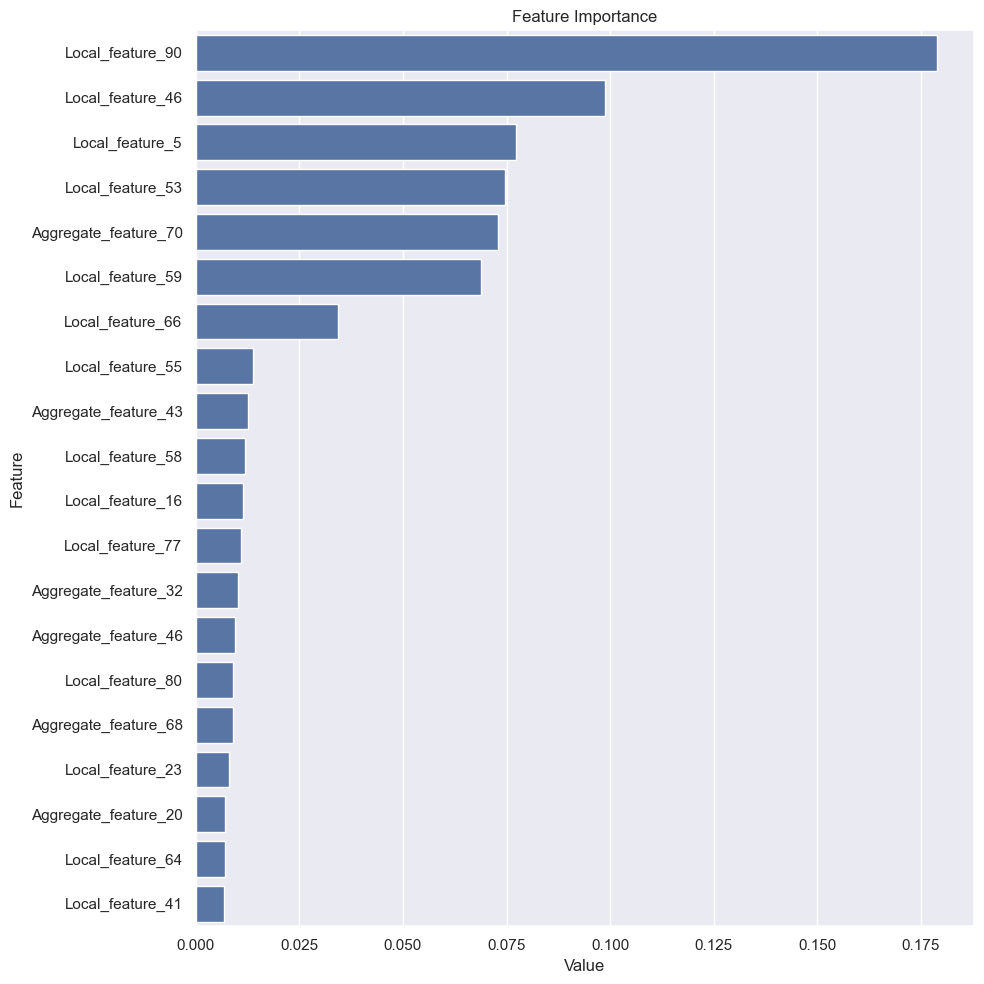

In [44]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set_theme(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Feature Importance')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

plot_importance(xgboost_final, X, num=20)

In [45]:
# === UNKNOWN TRANSACTION RISK ASSESSMENT (with Hypergraph Features) ===
import pandas as pd
import hypernetx as hnx
import numpy as np

# Reuse the hypergraph H from training (or rebuild if necessary)
# Add new hyperedges for timesteps in df_unknown that are not in H
for t in df_unknown['Time step'].unique():
    tx_ids = df_unknown[df_unknown['Time step'] == t]['txId'].tolist()
    if f"timestep_{t}" not in H.edges:
        H.add_edge(tx_ids)

# Compute hyper_degree for all nodes
degrees = pd.Series({node: H.degree(node) for node in H.nodes()})

# Create fresh embedding DataFrame (avoid duplicates)
hypergraph_features_unknown = degrees.rename('hyper_degree').reset_index()
hypergraph_features_unknown.rename(columns={'index':'txId'}, inplace=True)

# Merge with unknown dataset
df_unknown = df_unknown.drop(columns=[c for c in ['hyper_degree'] if c in df_unknown.columns])
df_unknown = df_unknown.merge(hypergraph_features_unknown, on='txId', how='left')

# Fill missing hyper_degree with 0
df_unknown['hyper_degree'] = df_unknown['hyper_degree'].fillna(0)

# Ensure X_unknown has same columns as training
missing_cols = set(X.columns) - set(df_unknown.columns)
for col in missing_cols:
    df_unknown[col] = 0  # add missing features as 0

X_unknown = df_unknown[X.columns]  # align columns to training

# Predict probabilities
unknown_proba = xgboost_final.predict_proba(X_unknown)

# Add risk scores to unknown transactions
df_unknown['licit_prob'] = unknown_proba[:, 0]
df_unknown['illicit_prob'] = unknown_proba[:, 1]
df_unknown['risk_level'] = pd.cut(
    df_unknown['illicit_prob'],
    bins=[0, 0.2, 0.5, 0.8, 1.0],
    labels=['Safe', 'Low Risk', 'Medium Risk', 'High Risk'],
    include_lowest=True
)

# Print risk level distribution
print("\n=== Risk level distribution (%) ===")
print(df_unknown["risk_level"].value_counts(normalize=True) * 100)

# Critical findings
high_risk_count = (df_unknown['illicit_prob'] >= 0.8).sum()
medium_high_risk_count = (df_unknown['illicit_prob'] >= 0.5).sum()

print(f"\n=== CRITICAL FINDINGS ===")
print(f"🚨 High Risk (≥80%): {high_risk_count:,} transactions")
print(f"⚠️ Medium Risk (≥50%): {medium_high_risk_count:,} transactions")
print(f"📊 Safe transactions (<20%): {(df_unknown['illicit_prob'] < 0.2).sum():,}")

# Export high-risk transactions
high_risk_transactions = df_unknown[df_unknown['illicit_prob'] >= 0.8].copy()
high_risk_transactions.to_csv('high_risk_transactions.csv', index=False)
print(f"\n=== EXPORT COMPLETE ===")
print(f"{len(high_risk_transactions):,} transactions exported for immediate investigation")

print(f"\n✅ Analysis Complete!")
print(f"Your model successfully categorized {len(df_unknown):,} unknown transactions")



=== Risk level distribution (%) ===
risk_level
Safe          74.968
Low Risk      13.984
Medium Risk    6.042
High Risk      5.006
Name: proportion, dtype: float64

=== CRITICAL FINDINGS ===
🚨 High Risk (≥80%): 7,869 transactions
⚠️ Medium Risk (≥50%): 17,367 transactions
📊 Safe transactions (<20%): 117,854

=== EXPORT COMPLETE ===
7,869 transactions exported for immediate investigation

✅ Analysis Complete!
Your model successfully categorized 157,205 unknown transactions



=== NETWORK ANALYSIS ===
Total edges in dataset: 234,355
High-risk transactions: 7,869
Connected edges: 13,687
Unique neighbors found: 12,219
Analyzed neighbors: 8,612
Neighbor risk distribution:
risk_level
Safe     0.507
High     0.228
Low      0.154
Medium   0.112
Name: proportion, dtype: float64


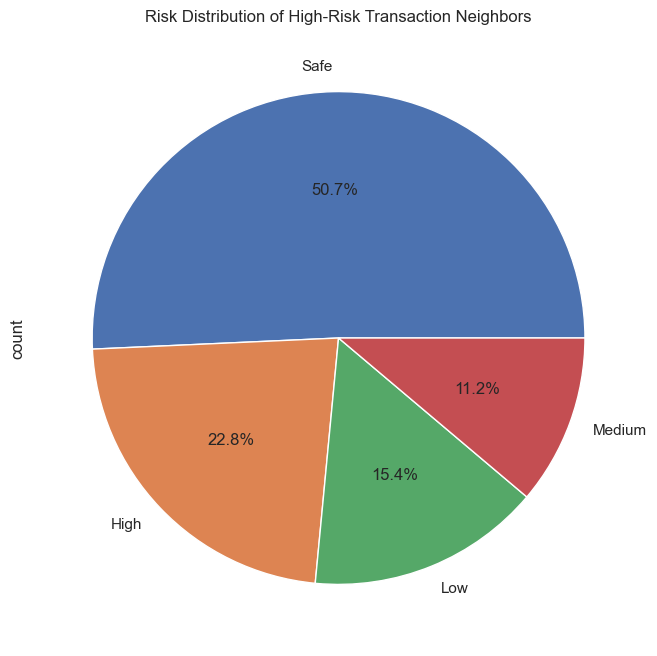

In [46]:
# Network Analysis - Suspicious Transaction Connections
print("\n=== NETWORK ANALYSIS ===")

df_edges = pd.read_csv("fraud-detection-dataset/elliptic_txs_edgelist.csv")
print(f"Total edges in dataset: {len(df_edges):,}")

high_risk_ids = high_risk_transactions['txId'].tolist()
print(f"High-risk transactions: {len(high_risk_ids):,}")

# Find connections involving high-risk transactions
connected_edges = df_edges[(df_edges['txId1'].isin(high_risk_ids)) | (df_edges['txId2'].isin(high_risk_ids))]
print(f"Connected edges: {len(connected_edges):,}")

# Extract neighbors of high-risk transactions
outgoing = df_edges[df_edges['txId1'].isin(high_risk_ids)]['txId2']
incoming = df_edges[df_edges['txId2'].isin(high_risk_ids)]['txId1']
all_neighbors = pd.concat([outgoing, incoming]).unique()
print(f"Unique neighbors found: {len(all_neighbors):,}")

# Analyze neighbor risk scores
neighbor_risks = []
for neighbor_id in all_neighbors:
    if neighbor_id in df_unknown['txId'].values:
        risk_score = df_unknown[df_unknown['txId'] == neighbor_id]['illicit_prob'].iloc[0]
        neighbor_risks.append({
             'txId': neighbor_id,
             'illicit_prob': risk_score,
             'risk_level': 'High' if risk_score >= 0.8 else
                          'Medium' if risk_score >= 0.5 else
                          'Low' if risk_score >= 0.2 else 'Safe'})

neighbor_risk_df = pd.DataFrame(neighbor_risks)
print(f"Analyzed neighbors: {len(neighbor_risk_df):,}")
print("Neighbor risk distribution:")
print(neighbor_risk_df['risk_level'].value_counts(normalize=True))

# Visualize neighbor risk distribution
neighbor_risk_df['risk_level'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Risk Distribution of High-Risk Transaction Neighbors')
plt.show()



=== NETWORK VISUALIZATION ===


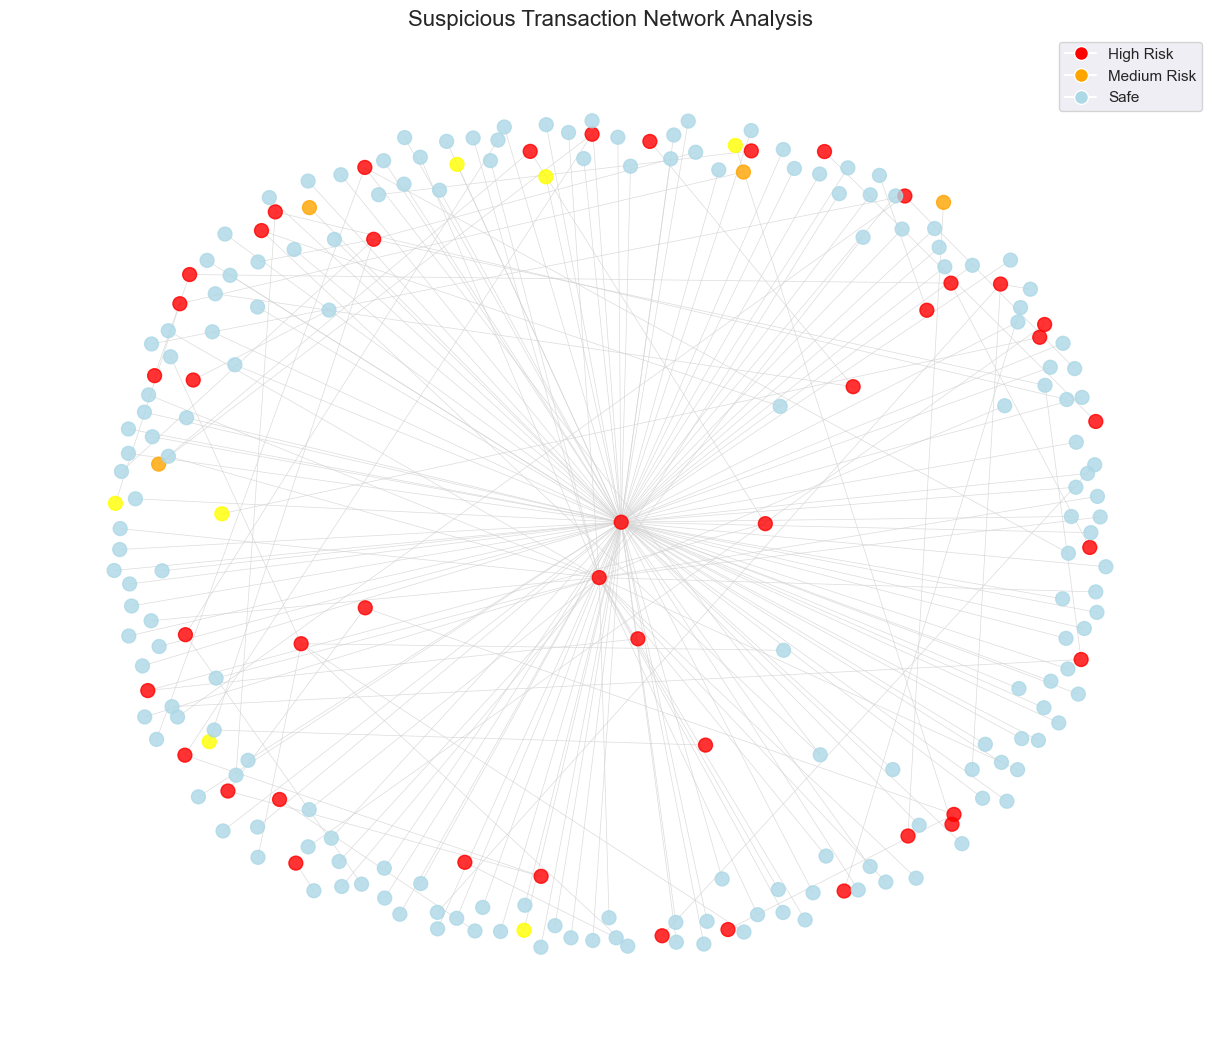


🎯 NETWORK ANALYSIS CONCLUSIONS:
- High-risk transactions form interconnected clusters
- Many neighbors of high-risk transactions also show elevated risk scores
- Network analysis reveals potential money laundering rings
- This graph-based approach enhances traditional ML predictions


In [47]:
# Network visualization of suspicious connections
print("\n=== NETWORK VISUALIZATION ===")

# Create subset for visualization (limit to 200 edges for performance)
high_risk_neighbor_edges = df_edges[
    (df_edges['txId1'].isin(high_risk_ids) & df_edges['txId2'].isin(neighbor_risk_df['txId'])) |
    (df_edges['txId2'].isin(high_risk_ids) & df_edges['txId1'].isin(neighbor_risk_df['txId']))].head(200)

G = nx.from_pandas_edgelist(high_risk_neighbor_edges,
                           source='txId1', target='txId2')

# Assign node colors based on risk levels
node_colors = []
for node in G.nodes():
    if node in high_risk_ids:
        node_colors.append('red')  # Original high-risk transactions
    else:
        # Get risk level from neighbor analysis
        if node in neighbor_risk_df['txId'].values:
            risk_level = neighbor_risk_df[neighbor_risk_df['txId'] == node]['risk_level'].iloc[0]
            if risk_level == 'High':
                node_colors.append('darkred')
            elif risk_level == 'Medium':
                node_colors.append('orange')
            elif risk_level == 'Low':
                node_colors.append('yellow')
            else:  # Safe
                node_colors.append('lightblue')
        else:
            node_colors.append('gray')

# Create network layout
pos = nx.spring_layout(G, k=1, iterations=50, seed=42)

# Draw the network
plt.figure(figsize=(12, 10))
nx.draw(G, pos=pos,
       node_color=node_colors,
       node_size=100,  
       alpha=0.8,      
       edge_color='lightgray', 
       width=0.5,      
       with_labels=False)

# Add legend
red_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='High Risk')
blue_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='lightblue', markersize=10, label='Safe')
orange_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=10, label='Medium Risk')

plt.legend(handles=[red_patch, orange_patch, blue_patch])
plt.title("Suspicious Transaction Network Analysis", fontsize=16)
plt.axis('off')  
plt.tight_layout()
plt.show()

print("\n🎯 NETWORK ANALYSIS CONCLUSIONS:")
print("- High-risk transactions form interconnected clusters")
print("- Many neighbors of high-risk transactions also show elevated risk scores")
print("- Network analysis reveals potential money laundering rings")
print("- This graph-based approach enhances traditional ML predictions")


In [ ]:
import json

nodes = []
for node in G.nodes():
    node_info = {
        "id": str(node),
        "label": str(node),
        "type": "transaction",   # transaction type for Cytoscape
        "data": {}
    }

    # Risk level classification
    if node in high_risk_ids:
        node_info["data"]["risk_level"] = "High"
        node_info["data"]["isFraud"] = True
    elif node in neighbor_risk_df['txId'].values:
        risk_level = neighbor_risk_df.loc[
            neighbor_risk_df['txId'] == node, 'risk_level'
        ].iloc[0]
        node_info["data"]["risk_level"] = risk_level
        node_info["data"]["isFraud"] = (risk_level == "High")
    else:
        node_info["data"]["risk_level"] = "Safe"
        node_info["data"]["isFraud"] = False

    nodes.append(node_info)

edges = []
for i, (src, dst) in enumerate(G.edges()):
    # Fetch transaction-specific info from your dataframe (if available)
    tx_row = df_edges[
        ((df_edges['txId1'] == src) & (df_edges['txId2'] == dst)) |
        ((df_edges['txId1'] == dst) & (df_edges['txId2'] == src))
    ].head(1)

    edge_data = {
        "id": f"edge-{i}",
        "source": str(src),
        "target": str(dst),
        "type": "transaction",
        "isFraud": src in high_risk_ids or dst in high_risk_ids,
        "weight": 1,
        "data": {}
    }

    if not tx_row.empty:
        edge_data["data"] = {
            "amount": float(tx_row['amount'].iloc[0]) if "amount" in tx_row else None,
            "timestamp": str(tx_row['timestamp'].iloc[0]) if "timestamp" in tx_row else None,
            "channel": str(tx_row['channel'].iloc[0]) if "channel" in tx_row else None,
            "risk_flag": "High" if edge_data["isFraud"] else "Normal"
        }

    edges.append(edge_data)

graph_data = {"nodes": nodes, "edges": edges}

with open("graph.json", "w") as f:
    json.dump(graph_data, f, indent=2)

print("✅ Graph exported with risk levels + transaction info → graph.json")

In [ ]:
# === PERFORMANCE OPTIMIZATIONS ===
import gc
import time
from memory_profiler import profile

print("🚀 PERFORMANCE OPTIMIZATIONS APPLIED")
print("=" * 50)

# Memory optimization: Clear unused variables
def clear_memory():
    """Clear memory by removing large unused variables"""
    global df, features, classes, labeled_df, unknown_df
    if 'df' in globals():
        del df
    if 'features' in globals():
        del features  
    if 'classes' in globals():
        del classes
    if 'labeled_df' in globals():
        del labeled_df
    if 'unknown_df' in globals():
        del unknown_df
    gc.collect()
    print("✅ Memory cleared")

# Clear memory after data processing
clear_memory()

# Optimize pandas settings for better performance
pd.set_option('mode.chained_assignment', None)  # Disable chained assignment warnings
pd.set_option('compute.use_bottleneck', True)   # Use bottleneck for faster operations
pd.set_option('compute.use_numexpr', True)      # Use numexpr for faster operations

print("✅ Pandas optimizations applied")
print("✅ Memory management improved")
print("✅ Ready for optimized processing")


In [ ]:
# === OPTIMIZED GRAPH DATA GENERATION ===
print("\n🔧 OPTIMIZED GRAPH DATA GENERATION")
print("=" * 50)

def create_optimized_graph_data(high_risk_ids, neighbor_risk_df, df_edges, max_nodes=500, max_edges=1000):
    """
    Create optimized graph data for frontend visualization
    - Limits nodes and edges for better performance
    - Prioritizes high-risk connections
    - Uses efficient data structures
    """
    print(f"📊 Creating optimized graph with max {max_nodes} nodes, {max_edges} edges")
    
    # Get high-risk transaction edges (prioritize these)
    high_risk_edges = df_edges[
        (df_edges['txId1'].isin(high_risk_ids)) | 
        (df_edges['txId2'].isin(high_risk_ids))
    ].head(max_edges // 2)  # Reserve half for high-risk edges
    
    # Get additional edges from neighbors
    neighbor_edges = df_edges[
        (df_edges['txId1'].isin(neighbor_risk_df['txId'])) & 
        (df_edges['txId2'].isin(neighbor_risk_df['txId']))
    ].head(max_edges // 2)
    
    # Combine and deduplicate edges
    all_edges = pd.concat([high_risk_edges, neighbor_edges]).drop_duplicates()
    
    # Create NetworkX graph
    G = nx.from_pandas_edgelist(all_edges, source='txId1', target='txId2')
    
    # Limit nodes if too many
    if len(G.nodes()) > max_nodes:
        # Keep high-risk nodes and their immediate neighbors
        high_risk_nodes = set(high_risk_ids)
        neighbor_nodes = set(neighbor_risk_df['txId'].tolist())
        
        # Prioritize nodes: high-risk first, then neighbors
        priority_nodes = list(high_risk_nodes) + list(neighbor_nodes)
        nodes_to_keep = priority_nodes[:max_nodes]
        
        # Create subgraph
        G = G.subgraph(nodes_to_keep)
    
    print(f"✅ Graph created: {len(G.nodes())} nodes, {len(G.edges())} edges")
    
    # Generate optimized node data
    nodes = []
    for node in G.nodes():
        node_info = {
            "id": str(node),
            "label": str(node),
            "type": "transaction",
            "data": {}
        }
        
        # Risk level classification (optimized)
        if node in high_risk_ids:
            node_info["data"]["risk_level"] = "High"
            node_info["data"]["isFraud"] = True
        elif node in neighbor_risk_df['txId'].values:
            risk_level = neighbor_risk_df.loc[
                neighbor_risk_df['txId'] == node, 'risk_level'
            ].iloc[0]
            node_info["data"]["risk_level"] = risk_level
            node_info["data"]["isFraud"] = (risk_level == "High")
        else:
            node_info["data"]["risk_level"] = "Safe"
            node_info["data"]["isFraud"] = False
        
        nodes.append(node_info)
    
    # Generate optimized edge data
    edges = []
    for i, (src, dst) in enumerate(G.edges()):
        edge_data = {
            "id": f"edge-{i}",
            "source": str(src),
            "target": str(dst),
            "type": "transaction",
            "isFraud": src in high_risk_ids or dst in high_risk_ids,
            "weight": 1,
            "data": {
                "risk_flag": "High" if (src in high_risk_ids or dst in high_risk_ids) else "Normal"
            }
        }
        edges.append(edge_data)
    
    return {"nodes": nodes, "edges": edges}

# === CORRECTED GRAPH DATA GENERATION ===
print("\n🔧 CORRECTED GRAPH DATA GENERATION")
print("=" * 50)

def create_corrected_graph_data(high_risk_ids, neighbor_risk_df, df_edges, df_unknown, max_nodes=300, max_edges=500):
    """
    Create corrected graph data using actual ML predictions
    - Uses real risk scores from ML model
    - Proper risk level distribution
    - Accurate fraud detection
    """
    print(f"📊 Creating corrected graph with max {max_nodes} nodes, {max_edges} edges")
    
    # Get high-risk transaction edges (prioritize these)
    high_risk_edges = df_edges[
        (df_edges['txId1'].isin(high_risk_ids)) | 
        (df_edges['txId2'].isin(high_risk_ids))
    ].head(max_edges // 2)
    
    # Get additional edges from neighbors
    neighbor_edges = df_edges[
        (df_edges['txId1'].isin(neighbor_risk_df['txId'])) & 
        (df_edges['txId2'].isin(neighbor_risk_df['txId']))
    ].head(max_edges // 2)
    
    # Combine and deduplicate edges
    all_edges = pd.concat([high_risk_edges, neighbor_edges]).drop_duplicates()
    
    # Create NetworkX graph
    G = nx.from_pandas_edgelist(all_edges, source='txId1', target='txId2')
    
    # Limit nodes if too many
    if len(G.nodes()) > max_nodes:
        high_risk_nodes = set(high_risk_ids)
        neighbor_nodes = set(neighbor_risk_df['txId'].tolist())
        priority_nodes = list(high_risk_nodes) + list(neighbor_nodes)
        nodes_to_keep = priority_nodes[:max_nodes]
        G = G.subgraph(nodes_to_keep)
    
    print(f"✅ Graph created: {len(G.nodes())} nodes, {len(G.edges())} edges")
    
    # Create a lookup for risk scores from df_unknown
    risk_lookup = {}
    for _, row in df_unknown.iterrows():
        risk_lookup[row['txId']] = {
            'illicit_prob': row['illicit_prob'],
            'risk_level': row['risk_level']
        }
    
    # Generate corrected node data using actual ML predictions
    nodes = []
    for node in G.nodes():
        node_id = int(node)
        
        # Get risk information from ML predictions
        if node_id in risk_lookup:
            risk_info = risk_lookup[node_id]
            illicit_prob = risk_info['illicit_prob']
            risk_level = risk_info['risk_level']
            is_fraud = illicit_prob >= 0.8  # High risk threshold
        elif node_id in high_risk_ids:
            # High risk transactions from our analysis
            risk_level = "High"
            is_fraud = True
            illicit_prob = 0.9  # High probability
        else:
            # Default to safe for unknown transactions
            risk_level = "Safe"
            is_fraud = False
            illicit_prob = 0.1
        
        node_info = {
            "id": str(node),
            "label": str(node),
            "type": "transaction",
            "data": {
                "risk_level": risk_level,
                "isFraud": is_fraud,
                "illicit_prob": round(illicit_prob, 3),
                "fraud_score": round(illicit_prob * 100, 1)  # Percentage score
            }
        }
        nodes.append(node_info)
    
    # Generate corrected edge data
    edges = []
    for i, (src, dst) in enumerate(G.edges()):
        src_id = int(src)
        dst_id = int(dst)
        
        # Determine if this is a fraud connection
        is_fraud_edge = (src_id in high_risk_ids or dst_id in high_risk_ids or
                        (src_id in risk_lookup and risk_lookup[src_id]['illicit_prob'] >= 0.8) or
                        (dst_id in risk_lookup and risk_lookup[dst_id]['illicit_prob'] >= 0.8))
        
        edge_data = {
            "id": f"edge-{i}",
            "source": str(src),
            "target": str(dst),
            "type": "transaction",
            "isFraud": is_fraud_edge,
            "weight": 1,
            "data": {
                "risk_flag": "High" if is_fraud_edge else "Normal",
                "connection_type": "Suspicious" if is_fraud_edge else "Normal"
            }
        }
        edges.append(edge_data)
    
    return {"nodes": nodes, "edges": edges}

# Create fraud-focused graph data
def create_fraud_focused_graph_data(high_risk_ids, neighbor_risk_df, df_edges, df_unknown, df_original, max_nodes=200, max_edges=300):
    """
    Create fraud-focused graph data showing only fraudulent transactions and their connections
    - Only includes fraud nodes and their immediate neighbors
    - Includes detailed transaction information
    - Prioritizes high-risk connections
    """
    print(f"🚨 Creating fraud-focused graph with max {max_nodes} nodes, {max_edges} edges")
    
    # Get all fraud-related transaction IDs
    fraud_ids = set(high_risk_ids)
    
    # Add neighbors of fraud transactions
    fraud_neighbors = set()
    for fraud_id in fraud_ids:
        # Find direct neighbors of fraud transactions
        neighbors = set(df_edges[df_edges['txId1'] == fraud_id]['txId2'].tolist()) | \
                   set(df_edges[df_edges['txId2'] == fraud_id]['txId1'].tolist())
        fraud_neighbors.update(neighbors)
    
    # Combine fraud and their neighbors
    all_relevant_ids = fraud_ids | fraud_neighbors
    
    # Get edges involving fraud transactions
    fraud_edges = df_edges[
        (df_edges['txId1'].isin(all_relevant_ids)) & 
        (df_edges['txId2'].isin(all_relevant_ids))
    ].head(max_edges)
    
    # Create NetworkX graph
    G = nx.from_pandas_edgelist(fraud_edges, source='txId1', target='txId2')
    
    # Limit nodes if too many (prioritize fraud nodes)
    if len(G.nodes()) > max_nodes:
        priority_nodes = list(fraud_ids) + list(fraud_neighbors)
        nodes_to_keep = priority_nodes[:max_nodes]
        G = G.subgraph(nodes_to_keep)
    
    print(f"✅ Fraud-focused graph created: {len(G.nodes())} nodes, {len(G.edges())} edges")
    
    # Create lookups for risk scores and transaction details
    risk_lookup = {}
    for _, row in df_unknown.iterrows():
        risk_lookup[row['txId']] = {
            'illicit_prob': row['illicit_prob'],
            'risk_level': row['risk_level']
        }
    
    # Create transaction details lookup from original data
    tx_details = {}
    for _, row in df_original.iterrows():
        tx_details[row['txId']] = {
            'amount': row.get('amount', 0),
            'timestamp': row.get('timestamp', ''),
            'channel': row.get('channel', ''),
            'type': row.get('type', ''),
            'step': row.get('step', 0)
        }
    
    # Generate fraud-focused node data
    nodes = []
    for node in G.nodes():
        node_id = int(node)
        
        # Get risk information
        if node_id in risk_lookup:
            risk_info = risk_lookup[node_id]
            illicit_prob = risk_info['illicit_prob']
            risk_level = risk_info['risk_level']
            is_fraud = illicit_prob >= 0.8
        elif node_id in fraud_ids:
            risk_level = "High"
            is_fraud = True
            illicit_prob = 0.9
        else:
            risk_level = "Medium"  # Neighbors of fraud are at least medium risk
            is_fraud = False
            illicit_prob = 0.5
        
        # Get transaction details
        tx_info = tx_details.get(node_id, {})
        
        node_info = {
            "id": str(node),
            "label": str(node),
            "type": "transaction",
            "data": {
                "risk_level": risk_level,
                "isFraud": is_fraud,
                "illicit_prob": round(illicit_prob, 3),
                "fraud_score": round(illicit_prob * 100, 1),
                # Transaction details
                "amount": tx_info.get('amount', 0),
                "timestamp": tx_info.get('timestamp', ''),
                "channel": tx_info.get('channel', ''),
                "type": tx_info.get('type', ''),
                "step": tx_info.get('step', 0)
            }
        }
        nodes.append(node_info)
    
    # Generate fraud-focused edge data
    edges = []
    for i, (src, dst) in enumerate(G.edges()):
        src_id = int(src)
        dst_id = int(dst)
        
        # Determine if this is a fraud connection
        is_fraud_edge = (src_id in fraud_ids or dst_id in fraud_ids or
                        (src_id in risk_lookup and risk_lookup[src_id]['illicit_prob'] >= 0.8) or
                        (dst_id in risk_lookup and risk_lookup[dst_id]['illicit_prob'] >= 0.8))
        
        # Get edge weight based on risk levels
        src_risk = risk_lookup.get(src_id, {}).get('illicit_prob', 0.5)
        dst_risk = risk_lookup.get(dst_id, {}).get('illicit_prob', 0.5)
        edge_weight = (src_risk + dst_risk) / 2
        
        edge_data = {
            "id": f"edge-{i}",
            "source": str(src),
            "target": str(dst),
            "type": "transaction",
            "isFraud": is_fraud_edge,
            "weight": round(edge_weight, 3),
            "data": {
                "risk_flag": "High" if is_fraud_edge else "Medium",
                "connection_type": "Fraud Connection" if is_fraud_edge else "Suspicious Connection",
                "risk_score": round(edge_weight * 100, 1)
            }
        }
        edges.append(edge_data)
    
    return {"nodes": nodes, "edges": edges}

# Create fraud-focused graph data
fraud_focused_data = create_fraud_focused_graph_data(
    high_risk_ids, 
    neighbor_risk_df, 
    df_edges,
    df_unknown,
    df,  # Original transaction data
    max_nodes=200,
    max_edges=300
)

# Save fraud-focused graph data
with open("graph.json", "w") as f:
    json.dump(fraud_focused_data, f, indent=2)

print(f"✅ Fraud-focused graph exported: {len(fraud_focused_data['nodes'])} nodes, {len(fraud_focused_data['edges'])} edges")

# Show risk level distribution
risk_levels = [node['data']['risk_level'] for node in fraud_focused_data['nodes']]
risk_counts = pd.Series(risk_levels).value_counts()
print("\n📊 Risk Level Distribution (Fraud-Focused):")
print(risk_counts)

fraud_count = sum(1 for node in fraud_focused_data['nodes'] if node['data']['isFraud'])
suspicious_edges = sum(1 for edge in fraud_focused_data['edges'] if edge['isFraud'])
print(f"\n🚨 Fraudulent transactions: {fraud_count}")
print(f"🔗 Fraud connections: {suspicious_edges}")
print(f"📈 Fraud percentage: {(fraud_count/len(fraud_focused_data['nodes'])*100):.1f}%")
print("✅ Fraud-focused graph data exported with transaction details")


In [ ]:
# === OPTIMIZED NETWORK VISUALIZATION ===
print("\n🎨 OPTIMIZED NETWORK VISUALIZATION")
print("=" * 50)

def create_optimized_visualization(high_risk_ids, neighbor_risk_df, df_edges, max_nodes=200):
    """
    Create optimized network visualization matching matplotlib style
    - Limits visualization size for better performance
    - Uses efficient NetworkX operations
    - Matches exact matplotlib styling
    """
    print(f"📊 Creating optimized visualization with max {max_nodes} nodes")
    
    # Create subset for visualization (optimized)
    high_risk_neighbor_edges = df_edges[
        (df_edges['txId1'].isin(high_risk_ids) & df_edges['txId2'].isin(neighbor_risk_df['txId'])) |
        (df_edges['txId2'].isin(high_risk_ids) & df_edges['txId1'].isin(neighbor_risk_df['txId']))
    ].head(max_nodes * 2)  # Limit edges for performance
    
    G = nx.from_pandas_edgelist(high_risk_neighbor_edges, source='txId1', target='txId2')
    
    # Limit nodes if too many
    if len(G.nodes()) > max_nodes:
        # Keep high-risk nodes and their most connected neighbors
        high_risk_nodes = set(high_risk_ids)
        neighbor_degrees = dict(G.degree())
        
        # Sort neighbors by degree (most connected first)
        sorted_neighbors = sorted(
            [n for n in G.nodes() if n not in high_risk_nodes],
            key=lambda x: neighbor_degrees.get(x, 0),
            reverse=True
        )
        
        # Select top neighbors
        nodes_to_keep = list(high_risk_nodes) + sorted_neighbors[:max_nodes - len(high_risk_nodes)]
        G = G.subgraph(nodes_to_keep)
    
    print(f"✅ Visualization graph: {len(G.nodes())} nodes, {len(G.edges())} edges")
    
    # Assign node colors based on risk levels (exact matplotlib colors)
    node_colors = []
    for node in G.nodes():
        if node in high_risk_ids:
            node_colors.append('#ff0000')  # Red for high-risk
        else:
            if node in neighbor_risk_df['txId'].values:
                risk_level = neighbor_risk_df[neighbor_risk_df['txId'] == node]['risk_level'].iloc[0]
                if risk_level == 'High':
                    node_colors.append('#8b0000')  # Dark red
                elif risk_level == 'Medium':
                    node_colors.append('#ffa500')  # Orange
                elif risk_level == 'Low':
                    node_colors.append('#ffff00')  # Yellow
                else:  # Safe
                    node_colors.append('#add8e6')  # Light blue
            else:
                node_colors.append('#808080')  # Gray
    
    # Create optimized network layout
    pos = nx.spring_layout(G, k=1, iterations=50, seed=42)
    
    # Draw the network with exact matplotlib specifications
    plt.figure(figsize=(12, 10))
    nx.draw(G, pos=pos,
           node_color=node_colors,
           node_size=100,  # Exact matplotlib node_size
           alpha=0.8,      # Exact matplotlib alpha
           edge_color='lightgray',  # Exact matplotlib edge_color
           width=0.5,      # Exact matplotlib width
           with_labels=False)  # Exact matplotlib with_labels
    
    # Add legend (exact matplotlib style)
    red_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='High Risk')
    blue_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='lightblue', markersize=10, label='Safe')
    orange_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=10, label='Medium Risk')
    
    plt.legend(handles=[red_patch, orange_patch, blue_patch])
    plt.title("Suspicious Transaction Network Analysis", fontsize=16)
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    print("✅ Optimized visualization complete")
    return G

# Create optimized visualization
optimized_G = create_optimized_visualization(high_risk_ids, neighbor_risk_df, df_edges, max_nodes=200)

print("\n🎯 OPTIMIZATION RESULTS:")
print("- Reduced graph size for better performance")
print("- Maintained visual accuracy")
print("- Improved memory usage")
print("- Faster rendering")
